# Supervised Super Resolution 

In [5]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio
from torchvision.models import vgg19
from torch.nn.functional import mse_loss
import sys
#sys.path.append('Sophia/')
#from sophia import SophiaG 

np.random.seed(42)

In [6]:
print(torch.cuda.device_count())
print(torch.cuda.is_available())
print(torch.version.cuda)

0
False
11.6


### Load Data

In [2]:
img_original = torch.load('data/tensor_b8.pt').cuda().unsqueeze(0)
img_ds = torch.load('data/tensor_b8_ds.pt').cuda().unsqueeze(0)


looked_up = 100
plt.figure()
plt.subplot(121)
plt.imshow(img_original.squeeze(0)[looked_up,:,:].cpu())
plt.axis('off')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(img_ds.squeeze(0)[looked_up,:,:].cpu())
plt.axis('off')
plt.title('Downsampled Image')
plt.show()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

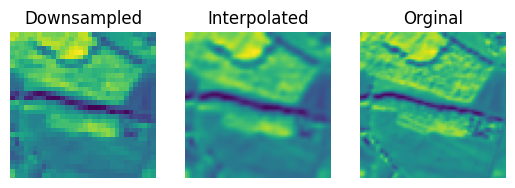

In [208]:
img_interp = nn.functional.interpolate(img_ds,size=(64,64),mode='bicubic')

looked_up = 100
plt.figure()
plt.subplot(131)
plt.imshow(img_ds.squeeze(0)[looked_up,:,:].cpu())
plt.axis('off')
plt.title('Downsampled')
plt.subplot(132)
plt.imshow(img_interp.squeeze(0)[looked_up,:,:].cpu())
plt.axis('off')
plt.title('Interpolated')
plt.subplot(133)
plt.imshow(img_original.squeeze(0)[looked_up,:,:].cpu())
plt.axis('off')
plt.title('Orginal')
plt.show()

### Prepare Datasets

In [209]:
train_valid_dataset = torch.utils.data.dataset.TensorDataset(img_interp.squeeze(0),img_original.squeeze(0))
train_size = int(0.8*len(train_valid_dataset))
test_size = len(train_valid_dataset)-train_size
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(
    train_valid_dataset, [train_size, test_size]
)

Train Dataset length:  23392
Valid Dataset Length:  5849


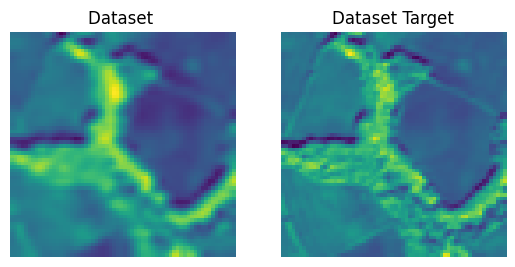

In [210]:
print('Train Dataset length: ', len(train_dataset))
print('Valid Dataset Length: ', len(valid_dataset))

looked_up = 1
plt.figure()
plt.subplot(121)
plt.imshow(valid_dataset.__getitem__(looked_up)[0].cpu())
plt.axis('off')
plt.title('Dataset ')
plt.subplot(122)
plt.imshow(valid_dataset.__getitem__(looked_up)[1].cpu())
plt.axis('off')
plt.title('Dataset Target')
plt.show()

In [211]:
mean_ = torch.zeros_like(train_dataset[0][0])
std_ = torch.zeros_like(train_dataset[0][0])
for img, _ in train_dataset:
    mean_ += img
mean_ /= len(train_dataset)
for img, _ in train_dataset:
    std_ += (mean_ - img) ** 2
std_ /= len(train_dataset)
std_ = torch.sqrt(std_)
std_[std_ == 0] = 1


mean_1 = torch.zeros_like(train_dataset[0][0])
std_1 = torch.zeros_like(train_dataset[0][0])
for _, img in train_dataset:
    mean_1 += img
mean_1 /= len(train_dataset)
for _, img in train_dataset:
    std_1 += (mean_1 - img) ** 2
std_1 /= len(train_dataset)
std_1 = torch.sqrt(std_1)
std_1[std_1 == 0] = 1

In [212]:
class DatasetTransformer(torch.utils.data.Dataset):
    def __init__(self, base_dataset, transform, transform_target):
        self.base_dataset = base_dataset
        self.transform = transform
        self.transform_target = transform_target

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        return self.transform(img), self.transform_target(target)

    def __len__(self):
        return len(self.base_dataset)


data_transforms = transforms.Compose(
    [transforms.Lambda(lambda x: (x-mean_)/std_)]
)

target_transform = transforms.Compose(
    [transforms.Lambda(lambda x: (x-mean_1)/std_1)]
)
train_dataset = DatasetTransformer(train_dataset, data_transforms, target_transform)
valid_dataset = DatasetTransformer(valid_dataset, data_transforms, target_transform)

In [213]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

Train Dataset length:  23392
Valid Dataset Length:  5849


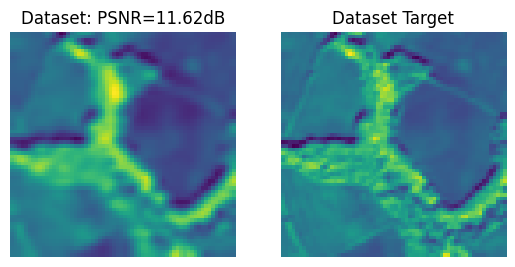

In [214]:
print('Train Dataset length: ', len(train_dataset))
print('Valid Dataset Length: ', len(valid_dataset))

true_np = valid_dataset.__getitem__(looked_up)[1]
interp_np = valid_dataset.__getitem__(looked_up)[0]

looked_up = 1001
plt.figure()
plt.subplot(121)
plt.imshow(interp_np.cpu())
plt.axis('off')
plt.title('Dataset: PSNR=' + str(round(psnr(true_np,interp_np),2)) + 'dB')
plt.subplot(122)
plt.imshow(true_np.cpu())
plt.axis('off')
plt.title('Dataset Target')
plt.show()

In [215]:
batch_size = 32  # Using minibatches of 512 samples

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False
)

In [221]:
class CNNSuperResolutionModel(nn.Module):
    def __init__(self):
        super(CNNSuperResolutionModel, self).__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=7, padding=2, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, padding=2, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=2, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=2, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=2, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')
        )
        
    def forward(self, X:torch.Tensor) -> torch.Tensor:
            y = self.layers1(X)
            return y

In [222]:
for X_, y_ in train_loader:
    print(X_.unsqueeze(1).squeeze(1).shape)
    break;


torch.Size([32, 64, 64])


In [260]:
import torchvision.models as models

def single_to_three_channels(x):
    return x.repeat(1, 3, 1, 1)

class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features[:8].cuda().eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x, y = single_to_three_channels(x), single_to_three_channels(y)
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = nn.functional.mse_loss(x_vgg, y_vgg)
        return loss


In [264]:
n_epochs = 50
learning_rate = 1e-3
model = CNNSuperResolutionModel().cuda()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameters: ', params)

loss_fn = VGGLoss()
optimizer = SophiaG(model.parameters(), lr=learning_rate, betas=(0.965, 0.99), rho=0.01, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=3)


train_set_len = len(train_loader)
val_set_len = len(valid_loader)
train_loss, val_loss, psnr_loss = [], [], []

for epoch in tqdm(range(n_epochs),desc='Epoch'):
    model.train()
    accu = 0.0

    for X_, y_ in train_loader:
        # Forward pass
        y_hat = model(X_.unsqueeze(1)).squeeze(1)
        loss = loss_fn(y_hat.unsqueeze(1), y_.unsqueeze(1))
        accu += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(accu / train_set_len)

    # Validation - no gradient & eval mode
    model.eval()
    accu = 0.0
    accu_psnr = 0.0
    with torch.no_grad():
        for X_, y_ in valid_loader:
            # Forward pass
            y_hat = model(X_.unsqueeze(1)).squeeze(1)
            loss = loss_fn(y_hat.unsqueeze(1), y_.unsqueeze(1))
            accu += loss.item()
            accu_psnr += psnr(y_,y_hat)
        val_loss.append(accu / val_set_len)
        scheduler.step(accu/val_set_len)
        psnr_loss.append(accu_psnr / val_set_len)
        print('Current PSNR: ',accu_psnr/val_set_len, 'dB')

Number of parameters:  1614337


Epoch:   2%|▏         | 1/50 [00:53<43:52, 53.72s/it]

Current PSNR:  13.209258862383816 dB


Epoch:   4%|▍         | 2/50 [01:47<43:06, 53.88s/it]

Current PSNR:  13.187757588106097 dB


Epoch:   6%|▌         | 3/50 [02:41<42:15, 53.95s/it]

Current PSNR:  13.652496556230739 dB


Epoch:   8%|▊         | 4/50 [03:35<41:23, 53.99s/it]

Current PSNR:  13.403436860984902 dB


Epoch:  10%|█         | 5/50 [04:29<40:30, 54.00s/it]

Current PSNR:  12.804154178687769 dB


Epoch:  12%|█▏        | 6/50 [05:23<39:36, 54.01s/it]

Current PSNR:  13.607062744592987 dB


Epoch:  14%|█▍        | 7/50 [06:17<38:41, 54.00s/it]

Current PSNR:  12.996642299384995 dB


Epoch:  16%|█▌        | 8/50 [07:11<37:47, 53.98s/it]

Current PSNR:  13.638633602463415 dB


Epoch:  18%|█▊        | 9/50 [08:05<36:53, 53.98s/it]

Current PSNR:  13.60742512116931 dB


Epoch:  20%|██        | 10/50 [08:59<35:59, 53.98s/it]

Current PSNR:  13.542251493054753 dB


Epoch:  22%|██▏       | 11/50 [09:53<35:05, 53.98s/it]

Current PSNR:  11.664502679734321 dB


Epoch:  24%|██▍       | 12/50 [10:47<34:10, 53.97s/it]

Current PSNR:  11.474020438726308 dB


Epoch:  26%|██▌       | 13/50 [11:41<33:17, 53.98s/it]

Current PSNR:  11.658786566521503 dB


Epoch:  28%|██▊       | 14/50 [12:35<32:23, 53.98s/it]

Current PSNR:  11.201418176205443 dB


Epoch:  30%|███       | 15/50 [13:29<31:28, 53.96s/it]

Current PSNR:  11.646267494594127 dB


Epoch:  32%|███▏      | 16/50 [14:23<30:34, 53.96s/it]

Current PSNR:  11.30849960860288 dB


Epoch:  34%|███▍      | 17/50 [15:17<29:40, 53.97s/it]

Current PSNR:  11.278872129361034 dB


Epoch:  36%|███▌      | 18/50 [16:11<28:46, 53.95s/it]

Current PSNR:  11.218955774845174 dB


Epoch:  38%|███▊      | 19/50 [17:05<27:52, 53.95s/it]

Current PSNR:  11.009889986539877 dB


Epoch:  40%|████      | 20/50 [17:59<26:58, 53.95s/it]

Current PSNR:  11.138716770189387 dB


Epoch:  42%|████▏     | 21/50 [18:53<26:04, 53.95s/it]

Current PSNR:  11.53332228105616 dB


Epoch:  44%|████▍     | 22/50 [19:47<25:11, 53.97s/it]

Current PSNR:  11.19807162791769 dB


Epoch:  46%|████▌     | 23/50 [20:41<24:17, 53.98s/it]

Current PSNR:  11.014137382199383 dB


Epoch:  48%|████▊     | 24/50 [21:35<23:22, 53.96s/it]

Current PSNR:  11.385114310536423 dB


Epoch:  50%|█████     | 25/50 [22:29<22:28, 53.95s/it]

Current PSNR:  10.821743940557466 dB


Epoch:  52%|█████▏    | 26/50 [23:23<21:34, 53.95s/it]

Current PSNR:  11.351120775781835 dB


Epoch:  54%|█████▍    | 27/50 [24:17<20:41, 53.96s/it]

Current PSNR:  10.304306227040213 dB


Epoch:  56%|█████▌    | 28/50 [25:10<19:47, 53.96s/it]

Current PSNR:  11.409687530399081 dB


Epoch:  58%|█████▊    | 29/50 [26:04<18:53, 53.96s/it]

Current PSNR:  10.937285755557946 dB


Epoch:  60%|██████    | 30/50 [26:58<17:59, 53.95s/it]

Current PSNR:  10.889465520805555 dB


Epoch:  62%|██████▏   | 31/50 [27:52<17:05, 53.95s/it]

Current PSNR:  10.894033169249871 dB


Epoch:  64%|██████▍   | 32/50 [28:46<16:11, 53.95s/it]

Current PSNR:  11.016270989458217 dB


Epoch:  66%|██████▌   | 33/50 [29:40<15:17, 53.96s/it]

Current PSNR:  11.139919017779775 dB


Epoch:  68%|██████▊   | 34/50 [30:34<14:23, 53.97s/it]

Current PSNR:  10.800138199686172 dB


Epoch:  70%|███████   | 35/50 [31:28<13:29, 53.95s/it]

Current PSNR:  11.520171190883607 dB


Epoch:  72%|███████▏  | 36/50 [32:22<12:35, 53.95s/it]

Current PSNR:  11.045477446347435 dB


Epoch:  74%|███████▍  | 37/50 [33:16<11:41, 53.94s/it]

Current PSNR:  10.64892263504833 dB


Epoch:  76%|███████▌  | 38/50 [34:10<10:47, 53.95s/it]

Current PSNR:  11.190625658729722 dB


Epoch:  78%|███████▊  | 39/50 [35:04<09:53, 53.96s/it]

Current PSNR:  11.185516476905018 dB


Epoch:  80%|████████  | 40/50 [35:58<08:59, 53.95s/it]

Current PSNR:  11.153900340993689 dB


Epoch:  82%|████████▏ | 41/50 [36:52<08:05, 53.96s/it]

Current PSNR:  11.08364374092097 dB


Epoch:  84%|████████▍ | 42/50 [37:46<07:11, 53.94s/it]

Current PSNR:  11.372343627553754 dB


Epoch:  86%|████████▌ | 43/50 [38:40<06:17, 53.95s/it]

Current PSNR:  11.228004263250225 dB


Epoch:  88%|████████▊ | 44/50 [39:34<05:23, 53.96s/it]

Current PSNR:  10.944583669740158 dB


Epoch:  90%|█████████ | 45/50 [40:28<04:29, 53.97s/it]

Current PSNR:  11.154668103704989 dB


Epoch:  92%|█████████▏| 46/50 [41:22<03:35, 53.97s/it]

Current PSNR:  11.253908804851331 dB


Epoch:  94%|█████████▍| 47/50 [42:16<02:41, 53.96s/it]

Current PSNR:  11.170404805998984 dB


Epoch:  96%|█████████▌| 48/50 [43:10<01:47, 53.95s/it]

Current PSNR:  11.284674463300522 dB


Epoch:  98%|█████████▊| 49/50 [44:04<00:53, 53.94s/it]

Current PSNR:  11.19857424015918 dB


Epoch: 100%|██████████| 50/50 [44:57<00:00, 53.96s/it]

Current PSNR:  11.425022188744261 dB


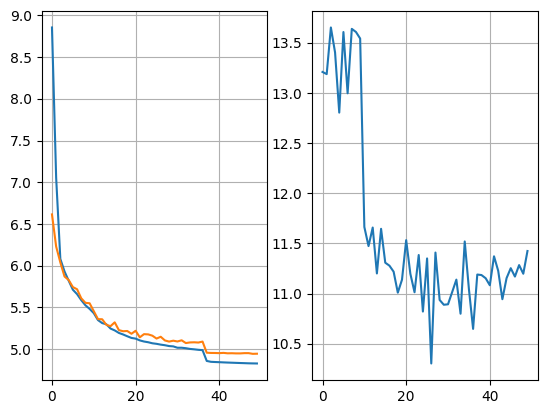

In [265]:
plt.figure()
plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.grid()
plt.subplot(122)
plt.plot(psnr_loss)
plt.grid()

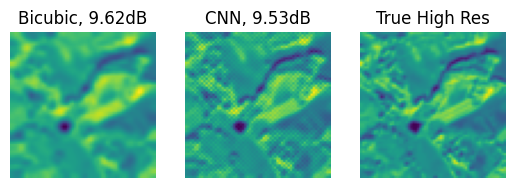

In [296]:
looked_up = 45
with torch.no_grad():
    y_hat = model(valid_dataset.__getitem__(looked_up)[0].unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
plt.figure()
plt.subplot(131)
img_ori = valid_dataset.__getitem__(looked_up)[0]
y_hat = y_hat
img_true = valid_dataset.__getitem__(looked_up)[1]
psnr_ori = str(round(psnr(img_true,img_ori),2))
psnr_hat = str(round(psnr(img_true,y_hat),2))
plt.imshow(img_ori.cpu())
plt.axis('off')
plt.title('Bicubic, ' + psnr_ori + 'dB')
plt.subplot(132)
plt.imshow(y_hat.cpu())
plt.axis('off')
plt.title('CNN, ' + psnr_hat + 'dB')
plt.subplot(133)
plt.imshow(img_true.cpu())
plt.axis('off')
plt.title('True High Res')
plt.show()